<a href="https://colab.research.google.com/github/trabbitt90/Text-Summarizer-of-South-Park-Episodes/blob/main/Text-Summarization-of-South-Park-Episodes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extractive and Abstractive Text Summarization of South Park Episodes 

## Overview

Text summarization can be a very powerful tool to quickly understand the important information contained in a provided text. Today, using Deep Learning, we are able to use models that do just that. Whether it be for medical documents, CNN news articles, or or even whole books text summarization can provide an overview of the text that can save time and resources. For my capstone project, I wanted to test some Text Summarization models on South Park episodes with the goal of providing a summary of what happens in the episode.


## Data
For this project we utilized the South Park Scripts Dataset from Kaggle. This data set has two files. One contains episode names, air date, season, episode number, and description of episode. While the other includes episode name, character and each characters lines. This is a large collection of text with over 300 episodes and 95000 lines. More detailed information on each dataset and their features are listed below:

### Episodes 
* `Title`- Title of the episode
* `Air Date`- Air date of the episode
* `Code`- Code for episode, it represents season and episode
* `#`- Episode number (all time)
* `Description`- General description for episode
* `Season`- Episode's season
* `Episode`- Episode number in season

### Lines
* `Title`- Title of the episode
* `Character`- Character
* `Line`- What the character said

For more information on the datasets and the sources behind them please visit the [South Park Scripts Dataset](https://www.kaggle.com/datasets/mustafacicek/south-park-scripts-dataset?select=SouthPark_Lines.csv) on the Kaggle website.

In [1]:
import tensorflow as tf

logger = tf.get_logger()


class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

## Data Preprocessing

In [2]:
# Importing necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Attention
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks, models, layers, preprocessing as kprocessing 
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [3]:
# Importing South Park epsiode dataframe and viewing first 5 rows

episodes = pd.read_csv('SouthPark_Episodes.csv')
episodes.head()

,Title,Air Date,Code,#,Description,Season,Episode
0,Cartman Gets an Anal Probe,"August 13, 1997",101,1,"While the boys are waiting for the school bus, Cartman explains the odd nightmare he had the previous night involving alien visitors.",1,1
1,Weight Gain 4000,"August 20, 1997",102,2,"When Cartman's environmental essay wins a national contest, America's sweetheart, Kathie Lee Gifford, comes to South Park to present the award.",1,2
2,Volcano,"August 27, 1997",103,3,"A weekend trip to experience the finer points of camping, fishing and blowing animals to smithereens is threatened by an erupting volcano.",1,3
3,Big Gay Al's Big Gay Boat Ride,"September 3, 1997",104,4,"When Stan discovers his new dog Sparky is gay, he becomes so confused he loses his will to play in the big Homecoming Football game against North Park.",1,4
4,An Elephant Makes Love to a Pig,"September 10, 1997",105,5,"Kyle's mom won't let him keep his new pet, an elephant because it's so huge. So the boys turn to Dr. Mephesto to genetically engineer a smaller elephant.",1,5


In [4]:
# Episodes dataframe information

episodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        309 non-null    object
 1   Air Date     309 non-null    object
 2   Code         309 non-null    int64 
 3   #            309 non-null    int64 
 4   Description  309 non-null    object
 5   Season       309 non-null    int64 
 6   Episode      309 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 17.0+ KB


Our episodes dataframe consists of 309 episodes. The main focus of this dataframe will be the title of the episode and it's description. The title will be used to merge the two dataframes while the description of each episode will be treated as our target variable.

In [5]:
# Checking for na values in dataframe

episodes.isna().sum()

Title          0
Air Date       0
Code           0
#              0
Description    0
Season         0
Episode        0
dtype: int64

We aren't missing any information in this dataset which is great. Our `Title` and `Description` features are object dtype which is appropriate. All other columns will be dropped from the dataframe. Lets import our lines dataset.

In [6]:
# Importing South Park lines dataframe and viewing first 5 rows

lines = pd.read_csv('SouthPark_Lines.csv')
lines

,Title,Character,Line
0,Cartman Gets an Anal Probe,Scene Description,At the bus stop.
1,Cartman Gets an Anal Probe,The Boys,"School days, school days, teacher's golden ru..."
2,Cartman Gets an Anal Probe,Kyle Broflovski,"Ah, damn it! My little brother's trying to follow me to school again."
3,Cartman Gets an Anal Probe,Ike Broflovski,Eat banana.
4,Cartman Gets an Anal Probe,Kyle,"Ike, you can't come to school with me. [Ike Chortles.]"
...,...,...,...
95315,South ParQ Vaccination Special,Cartman,[turns to face Clyde] Yeah?
95316,South ParQ Vaccination Special,Clyde,"[standing with Jimmy and an unnamed Hispanic kid] Dude, they're reopening Casa Bonita this weekend. Do you wanna come with us?"
95317,South ParQ Vaccination Special,Cartman,"[he takes off his mask] Casa Bonita?! Hell yeah, I'll come! [his face falls] Oh, wait! I can't! I have fucking Kenny this weekend! [he throws his hat onto the ground in anger] Shit! [he walks away..."
95318,South ParQ Vaccination Special,Scene Description,"Fourth grade classroom. Mr. Garrison opens the door and walks inside, dropping his books on his desk and taking a seat. He puts Mr. Hat on his hand, smiling."


In [7]:
# Lines dataframe information

lines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95320 entries, 0 to 95319
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      95320 non-null  object
 1   Character  95320 non-null  object
 2   Line       95308 non-null  object
dtypes: object(3)
memory usage: 2.2+ MB


Our lines dataframe has 95320 entries in our `Title` and `Character` columns. It appears we are missing 12 entries in our `Line` column. Lets investigate those instances.

In [8]:
# Viewing instances where Line entry is NaN

lines.loc[lines['Line'].isna()] 

,Title,Character,Line
24722,Do the Handicapped Go to Hell?,Cartman,NaN
24724,Do the Handicapped Go to Hell?,Cartman,NaN
27432,A Very Crappy Christmas,"Stan, Kyle",NaN
30605,Osama bin Laden Has Farty Pants,Osama bin Laden,NaN
31625,Here Comes the Neighborhood,Bill Cosby,NaN
45847,Quest for Ratings,Stan,NaN
50080,Trapped in the Closet,R. Kelly,NaN
50391,Free Willzyx,Manuel,NaN
70688,City Sushi,Field reporter,NaN
70823,City Sushi,Field reporter,NaN


Dropping 12 lines from a dataframe that contain 95000 lines seems rather inconsequntial, lets drop those instances from the dataframe.

In [9]:
# Dropping NaN values from lines dataframe
lines.dropna(inplace=True)

Lets do some EDA on our lines dataframe to get a better idea of line distribution in South Park's dialouge.

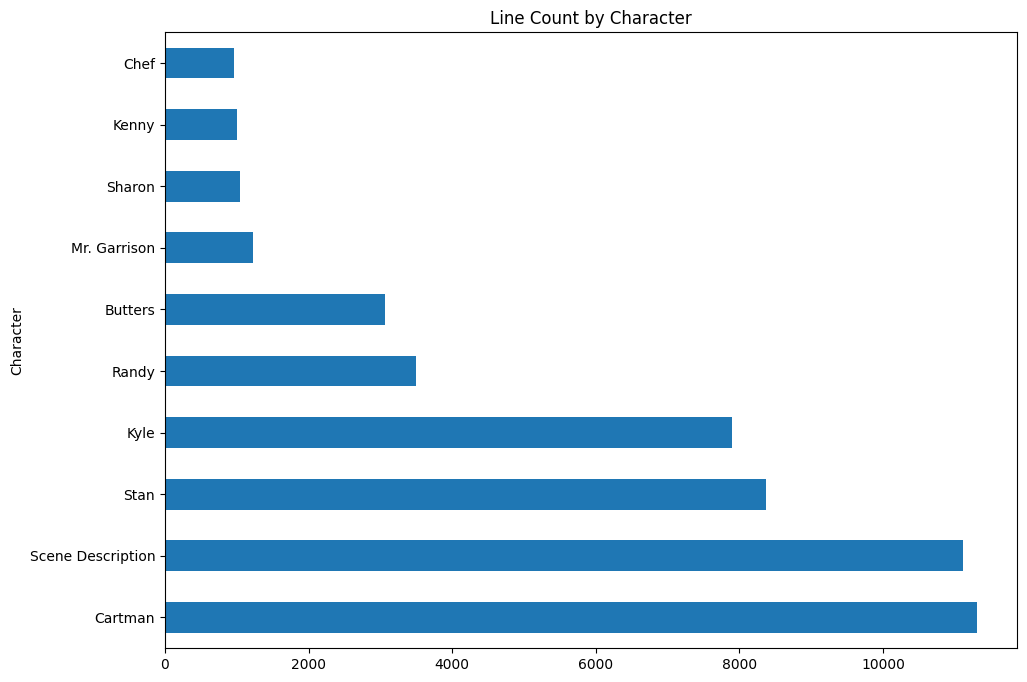

In [10]:
from matplotlib import rcParams
import seaborn as sns


# Plotting top 10 characters based on number of lines
lines['Character'].value_counts().head(10).plot(kind='barh', 
                                                figsize=(11,8), 
                                                title='Line Count by Character',
                                                xlabel='Character',
                                                ylabel='Number of Lines');

If you are familiar with the show we can see that the usual suspects such as Cartman, Stan and Kyle have the lions share of the dialouge in the show. An interesting observation is the Scene Description character has the second most lines, this makes sense as that character is used to describe the setting throughout each episode. For clairity we may want to consider removing this character from the text entirely.

We now want to concatenate the lines of each episode so that we have an entire script of dialouge contianed in each row that is associated with a single episode title.


In [11]:
# Concatenate the string
lines['Line'] = lines.groupby(['Title'])['Line'].transform(lambda x : ' '.join(x)) 
lines = lines.drop_duplicates('Title')

# Show the dataframe
lines.head()

,Title,Character,Line
0,Cartman Gets an Anal Probe,Scene Description,"At the bus stop. School days, school days, teacher's golden ru... Ah, damn it! My little brother's trying to follow me to school again. Eat banana. Ike, you can't come to school with me. [Ike Chor..."
507,Weight Gain 4000,Scene Description,"Mr. Garrison's classroom. Hey Stan, did you see that rainbow this morning? Yeah, it was huge. Ugh, I hate those things. Nobody hates rainbows. Yeah, what's there to hate about rainbows? Well, you ..."
904,Volcano,Scene Description,"In front of Cartman's house. Jimbo, Ned, and the boys are waiting for Cartman. Now you be careful, Eric. The woods can be very dangerous. Okay, Mom. Ready to go hunting, Cartman? Yeah, my Uncle Ji..."
1307,Big Gay Al's Big Gay Boat Ride,Scene Description,"Bus Stop. Hey, where's the school bus? We're gonna be late for football practice. A dog walks up to the boys. Hiya, Sparky. [Looking] Who's that? That's my new dog Sparky. He followed me to the bu..."
1832,An Elephant Makes Love to a Pig,Scene Description,"Bus Stop. Hey Stan, where'd you get that black eye? Nothing, I mu-I mean, nowhere. Your sister beat you up again, huh? No! Eheh, you know, heh, your sister kicked your ass. She's just pissed off '..."


Perfect! We are now ready to merge our two dataframe using the title of each episode. Before we do that lets make sure we have the same number of episodes in each.

In [12]:
print('Number of episodes in episodes dataframe:', len(episodes.Title))
print('Number of episodes in lines dataframe:', len(lines.Title))

Number of episodes in episodes dataframe: 309
Number of episodes in lines dataframe: 309


We have the same number of episodes in each dataframe which is great. Next we are going to drop the `Character` column from the lines dataframe. I am doing this for two reasons. First, this text is a dialouge and the character names are often spoken to eachother, therefore there is little information lost by taking out the text that specifies who is speaking. Second, if we were to add the character names before each sentence it would add more words for our model to remember making it more confusing for our model to understand and it makes it computationally expensive. 

In [13]:
# Dropping Character column from lines dataframe

lines = lines.drop('Character', axis=1)
lines.head()

,Title,Line
0,Cartman Gets an Anal Probe,"At the bus stop. School days, school days, teacher's golden ru... Ah, damn it! My little brother's trying to follow me to school again. Eat banana. Ike, you can't come to school with me. [Ike Chor..."
507,Weight Gain 4000,"Mr. Garrison's classroom. Hey Stan, did you see that rainbow this morning? Yeah, it was huge. Ugh, I hate those things. Nobody hates rainbows. Yeah, what's there to hate about rainbows? Well, you ..."
904,Volcano,"In front of Cartman's house. Jimbo, Ned, and the boys are waiting for Cartman. Now you be careful, Eric. The woods can be very dangerous. Okay, Mom. Ready to go hunting, Cartman? Yeah, my Uncle Ji..."
1307,Big Gay Al's Big Gay Boat Ride,"Bus Stop. Hey, where's the school bus? We're gonna be late for football practice. A dog walks up to the boys. Hiya, Sparky. [Looking] Who's that? That's my new dog Sparky. He followed me to the bu..."
1832,An Elephant Makes Love to a Pig,"Bus Stop. Hey Stan, where'd you get that black eye? Nothing, I mu-I mean, nowhere. Your sister beat you up again, huh? No! Eheh, you know, heh, your sister kicked your ass. She's just pissed off '..."


As we mentioned before, the only information we need from our episodes dataframe is the `Title` and `Description` features. Lets make a new episodes dataframe that consists of only those columns.

In [14]:
# Creating a new episodes dataframe

episodes = episodes[['Title', 'Description']]
episodes

,Title,Description
0,Cartman Gets an Anal Probe,"While the boys are waiting for the school bus, Cartman explains the odd nightmare he had the previous night involving alien visitors."
1,Weight Gain 4000,"When Cartman's environmental essay wins a national contest, America's sweetheart, Kathie Lee Gifford, comes to South Park to present the award."
2,Volcano,"A weekend trip to experience the finer points of camping, fishing and blowing animals to smithereens is threatened by an erupting volcano."
3,Big Gay Al's Big Gay Boat Ride,"When Stan discovers his new dog Sparky is gay, he becomes so confused he loses his will to play in the big Homecoming Football game against North Park."
4,An Elephant Makes Love to a Pig,"Kyle's mom won't let him keep his new pet, an elephant because it's so huge. So the boys turn to Dr. Mephesto to genetically engineer a smaller elephant."
...,...,...
304,Turd Burglars,Kyle’s mom looks so good after her fecal transplant that everyone wants to get their hands on her goods. Cartman and the boys jump into the quest for the best microbiome.
305,Basic Cable,Scott Malkinson’s future with the new girl in his class depends on him getting the latest and greatest streaming platform. Scott’s dad works for the local cable company and refuses to move beyond ...
306,Christmas Snow,It's a bleak Christmas Season in South Park this year and it's all Santa's fault. He is single handedly stealing the joy from the holiday. The town just wants their Christmas Spirit back but that ...
307,The Pandemic Special,Randy comes to terms with his role in the COVID-19 outbreak as the on-going pandemic presents continued challenges to the citizens of South Park. The kids happily head back to school but nothing r...


We are now ready to merge the two dataframes on their respective `Title` columns

In [15]:
# Merging two dataframes into SP_df dataframe

SP_df = pd.merge(lines, episodes, left_on='Title', right_on='Title')
SP_df.head()

,Title,Line,Description
0,Cartman Gets an Anal Probe,"At the bus stop. School days, school days, teacher's golden ru... Ah, damn it! My little brother's trying to follow me to school again. Eat banana. Ike, you can't come to school with me. [Ike Chor...","While the boys are waiting for the school bus, Cartman explains the odd nightmare he had the previous night involving alien visitors."
1,Weight Gain 4000,"Mr. Garrison's classroom. Hey Stan, did you see that rainbow this morning? Yeah, it was huge. Ugh, I hate those things. Nobody hates rainbows. Yeah, what's there to hate about rainbows? Well, you ...","When Cartman's environmental essay wins a national contest, America's sweetheart, Kathie Lee Gifford, comes to South Park to present the award."
2,Volcano,"In front of Cartman's house. Jimbo, Ned, and the boys are waiting for Cartman. Now you be careful, Eric. The woods can be very dangerous. Okay, Mom. Ready to go hunting, Cartman? Yeah, my Uncle Ji...","A weekend trip to experience the finer points of camping, fishing and blowing animals to smithereens is threatened by an erupting volcano."
3,Big Gay Al's Big Gay Boat Ride,"Bus Stop. Hey, where's the school bus? We're gonna be late for football practice. A dog walks up to the boys. Hiya, Sparky. [Looking] Who's that? That's my new dog Sparky. He followed me to the bu...","When Stan discovers his new dog Sparky is gay, he becomes so confused he loses his will to play in the big Homecoming Football game against North Park."
4,An Elephant Makes Love to a Pig,"Bus Stop. Hey Stan, where'd you get that black eye? Nothing, I mu-I mean, nowhere. Your sister beat you up again, huh? No! Eheh, you know, heh, your sister kicked your ass. She's just pissed off '...","Kyle's mom won't let him keep his new pet, an elephant because it's so huge. So the boys turn to Dr. Mephesto to genetically engineer a smaller elephant."


In [16]:
# Checking for Nan values in new dataframe

SP_df.isna().sum()

Title          0
Line           0
Description    0
dtype: int64

In [17]:
# Renaming our Line and Description columns
SP_df.rename(columns={'Line': 'Text', "Description": "Summary" }, inplace=True)

# Viewing exxample of dialogue and its associated summary
print("---- Episode Dialogue ----")
print(SP_df.Text[0])
print("---- Summary ----")
print(SP_df.Summary[0])

---- Episode Dialogue ----
At the bus stop. School days, school days, teacher's golden ru... Ah, damn it! My little brother's trying to follow me to school again. Eat banana. Ike, you can't come to school with me. [Ike Chortles.] Yeah, go home you little dildo! Dude, don't call my brother a dildo! What's a dildo? Well, I don't know...[He faces Cartman and points at him.] and I'll bet Cartman doesn't know either! I know what it means! Well, what? I'm not telling you. What's a dildo, Kenny? (It's a plastic dick that goes in a vagina.) [The others laugh.] He-yeah, that's what Kyle's little brother is all right! [Kyle swings Ike by his feet, knocking Cartman down.] Ow! [Ike Laughs.] Dude, that kicks ass! Yeah, check this one out. Ready Ike? Kick the baby! Don't kick the baby. Kick the baby. He kicks Ike like a football, who lands, knocking down four mailboxes. Cartman yawns. Whoa, Cartman! Looks like you didn't get much sleep last night. That's 'cause I was having these... bogus nightmares

We now have a dataframe that we can use for our text summarization modeling. We will start by using an extractive approach using Gensim.

#  Gensim TextRank Model 

Text summarization can broadly be divided into two categories: **Extractive Summarization** and **Abstractive Summarization**. Extractive summarization compiles the most important words, sentences or pharases from a corpus into a concise summary. This approach does not neccessarily aim to understand the meaning of the text, therefore the summary that is produced is just a subset of the original text. Alternatively, abstractive summarization models use more advanced NLP techniques to understand semantics and structure and can therefore have new phrases and sentences that are not contained in the original text.

We will take an iterative approach to our model building by first starting with an extractive summarization model using TextRank from Gensim, which we will use as our baseline. We can then work our way to more advanced NLP models for abstractive summarization. 

Gensim TextRank summarizer is an unsupervised algorithm that summarizes text by extracting the most important sentences from it. It takes two arguments, the first will be a provided text while the second will be a ratio which specifies what fraction of sentences in the original text should be returned as output. 

We would like to match our output as closely as possible to the provided summary (our target variable). Let's find the average ratio of length of summary to length of text in our dataframe.



In [18]:
# Fining the ratio of text to summary

ratios = []
for i in range(len(SP_df)):
    ratios.append(len(SP_df['Summary'][i]) / len(SP_df['Text'][i]))
SP_df['Ratio'] = ratios
SP_df.Ratio.mean()

0.005029402376588137

The length of our summary is .05% of the length of our dialogue, which is very small. Let's see how our textrank model performs.

In [19]:
#Importing gensim 3.8.3

!pip install gensim==3.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
# Importing gensim
import gensim

# Defining textrank function
def textrank(corpus, ratio=None):        
    lst_summaries = [gensim.summarization.summarize(txt,  
                     ratio=ratio) for txt in corpus]    
    return lst_summaries

# Apply the function to corpus
SP_df['predicted'] = textrank(corpus=SP_df.Text, ratio=.005)

In [21]:
# Comparing first 5 summaries

for i in range(5):
  print("-----------------Summary----------------")
  print(SP_df.Summary[i])
  print('-----------------Predicted--------------')
  print(SP_df.predicted[i])
  print('\n')

-----------------Summary----------------
While the boys are waiting for the school bus, Cartman explains the odd nightmare he had the previous night involving alien visitors.
-----------------Predicted--------------
(It's a plastic dick that goes in a vagina.) [The others laugh.] He-yeah, that's what Kyle's little brother is all right!
I can't just sit here, I have to help my stupid brother, or I'll come home without him and my dad will start yelling, "Where's your brother, Kyle?" "You weren't looking out for your little brother, Kyle?" [Whispering.] Okay, okay, let's ditch school and go find him.
All you have to do is fart some more, Cartman, and the Visitors are sure to come!


-----------------Summary----------------
When Cartman's environmental essay wins a national contest, America's sweetheart, Kathie Lee Gifford, comes to South Park to present the award.
-----------------Predicted--------------
Children, as you all know, Miss Kathie Lee Gifford will be in South Park to present t

Viewing the summaries above (sorry for the language) you can see that the textrank algorithm did a fairly good job at capturing the information in the dialogue on certain occasions while on others it did not. But for an unsupervised extractive approach to summarization the information contained in the output is pretty impressive.

For this analysis we will be using ROUGE score to measure just how well our models produced a viable summary. In particular we will be using ROUGE-1, ROUGE-2 and ROUGE-L.

ROUGE-1 refers to the overlap of unigram (each word) between the system and reference summaries.

ROUGE-2 refers to the overlap of bigrams between the system and reference summaries.

ROUGE-L: Takes into account sentence level structure similarity naturally and identifies longest co-occurring in sequence n-grams automatically.

In [22]:
# Installing ROUGE
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:

import rouge
score_1 = []
score_2 = []
score_L = []

for i in range(len(SP_df)):   
    rouge_score = rouge.Rouge()    
    scores = rouge_score.get_scores(SP_df.Summary[i], SP_df.predicted[i], avg=True)       
    score_1.append(round(scores['rouge-1']['f'], 2))
    score_2.append(round(scores['rouge-2']['f'], 2))
    score_L.append(round(scores['rouge-l']['f'], 2))    
    
SP_df["Score_1"] = score_1
SP_df['Score_2'] = score_2
SP_df['Score_L'] = score_L

In [24]:
SP_df.head()

,Title,Text,Summary,Ratio,predicted,Score_1,Score_2,Score_L
0,Cartman Gets an Anal Probe,"At the bus stop. School days, school days, teacher's golden ru... Ah, damn it! My little brother's trying to follow me to school again. Eat banana. Ike, you can't come to school with me. [Ike Chor...","While the boys are waiting for the school bus, Cartman explains the odd nightmare he had the previous night involving alien visitors.",0.005584,"(It's a plastic dick that goes in a vagina.) [The others laugh.] He-yeah, that's what Kyle's little brother is all right!\nI can't just sit here, I have to help my stupid brother, or I'll come hom...",0.09,0.00,0.09
1,Weight Gain 4000,"Mr. Garrison's classroom. Hey Stan, did you see that rainbow this morning? Yeah, it was huge. Ugh, I hate those things. Nobody hates rainbows. Yeah, what's there to hate about rainbows? Well, you ...","When Cartman's environmental essay wins a national contest, America's sweetheart, Kathie Lee Gifford, comes to South Park to present the award.",0.006676,"Children, as you all know, Miss Kathie Lee Gifford will be in South Park to present the award to some kid for an essay.\nMr. Garrison's Bed. He hears Kathie Lee singing in his head: ""If they could...",0.26,0.16,0.23
2,Volcano,"In front of Cartman's house. Jimbo, Ned, and the boys are waiting for Cartman. Now you be careful, Eric. The woods can be very dangerous. Okay, Mom. Ready to go hunting, Cartman? Yeah, my Uncle Ji...","A weekend trip to experience the finer points of camping, fishing and blowing animals to smithereens is threatened by an erupting volcano.",0.006777,"Jimbo, Ned, and the boys are waiting for Cartman.\nLooks like about a .46 gauge, Ned. It's coming right for us!",0.10,0.00,0.05
3,Big Gay Al's Big Gay Boat Ride,"Bus Stop. Hey, where's the school bus? We're gonna be late for football practice. A dog walks up to the boys. Hiya, Sparky. [Looking] Who's that? That's my new dog Sparky. He followed me to the bu...","When Stan discovers his new dog Sparky is gay, he becomes so confused he loses his will to play in the big Homecoming Football game against North Park.",0.006211,"Yeah dude, I think your dog is gay.\nWell, how about Stan, our little South Park quarterback star?\nHey, speaking of pounding ass, here comes Stan's little homo dog.",0.11,0.00,0.08
4,An Elephant Makes Love to a Pig,"Bus Stop. Hey Stan, where'd you get that black eye? Nothing, I mu-I mean, nowhere. Your sister beat you up again, huh? No! Eheh, you know, heh, your sister kicked your ass. She's just pissed off '...","Kyle's mom won't let him keep his new pet, an elephant because it's so huge. So the boys turn to Dr. Mephesto to genetically engineer a smaller elephant.",0.006620,"(Hey you guys, I talked to Garrison and he told me that they're almost the same.) Well yeah, but pigs aren't smart, like elephants.\nOh yeah, I bet I can genetically clone a whole human being befo...",0.16,0.00,0.16


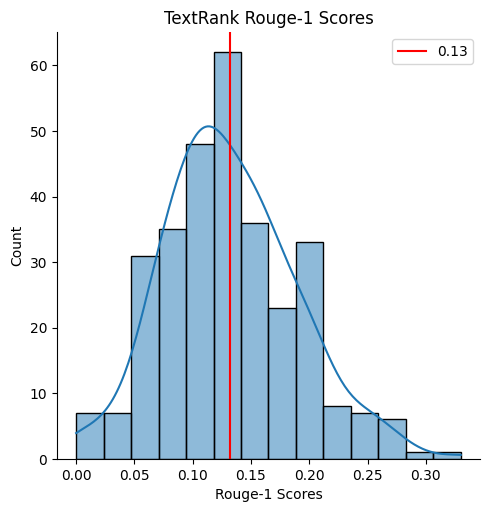

In [25]:
sns.displot(SP_df["Score_1"], kde=True)
plt.xlabel("Rouge-1 Scores")
plt.ylabel("Count")
plt.title('TextRank Rouge-1 Scores')
plt.axvline(SP_df.Score_1.mean(),
            color='red', label=round(SP_df.Score_1.mean(),2))
plt.legend();

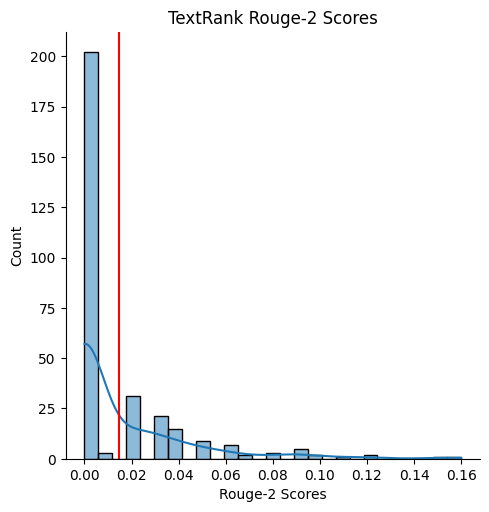

In [26]:
sns.displot(SP_df["Score_2"], kde=True)
plt.xlabel("Rouge-2 Scores")
plt.ylabel("Count")
plt.title('TextRank Rouge-2 Scores')
plt.axvline(SP_df.Score_2.mean(),
            color='red');

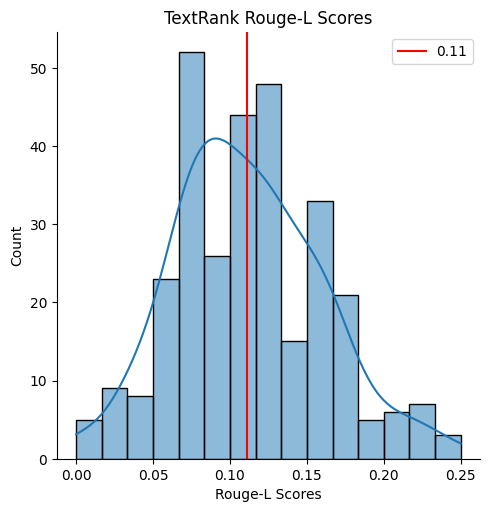

In [27]:
sns.displot(SP_df["Score_L"], kde=True)
plt.xlabel("Rouge-L Scores")
plt.ylabel("Count")
plt.title('TextRank Rouge-L Scores')
plt.axvline(SP_df.Score_L.mean(),
            color='red', label=round(SP_df.Score_L.mean(),2))
plt.legend();

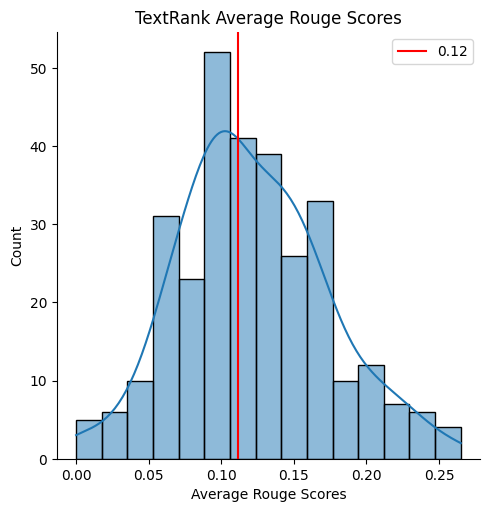

In [28]:
SP_df['Score_avg'] = np.mean(SP_df[['Score_1', 'Score_L']], axis=1)
sns.displot(SP_df["Score_avg"], kde=True)
plt.xlabel("Average Rouge Scores")
plt.ylabel("Count")
plt.title('TextRank Average Rouge Scores')
plt.axvline(SP_df.Score_L.mean(),
            color='red', label=round(SP_df.Score_avg.mean(),2))
plt.legend();

# Seq2Seq Modeling

A Sequence to Sequence (Seq2Seq) model involves any problem that deals with sequenctial information. In regards to natural language processing, this could be useful in translating a text to a different language, providing sentiment analysis, or in our case producing a summary of a text. 

We will provide a Seq2Seq model with an input of sequence with a certain length of words (dialouge), and hopefully produce an output with a differenct length of words (summary). First we need clean the text so that we can then tokenize it.

In [29]:
# Importing useful libraries to clean text

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import string
import re 
from nltk.stem.wordnet import WordNetLemmatizer
import contractions

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
# Creating seq-2-seq dataframe

s2s_df = SP_df[['Title', 'Text', 'Summary']]
s2s_df.head()

,Title,Text,Summary
0,Cartman Gets an Anal Probe,"At the bus stop. School days, school days, teacher's golden ru... Ah, damn it! My little brother's trying to follow me to school again. Eat banana. Ike, you can't come to school with me. [Ike Chor...","While the boys are waiting for the school bus, Cartman explains the odd nightmare he had the previous night involving alien visitors."
1,Weight Gain 4000,"Mr. Garrison's classroom. Hey Stan, did you see that rainbow this morning? Yeah, it was huge. Ugh, I hate those things. Nobody hates rainbows. Yeah, what's there to hate about rainbows? Well, you ...","When Cartman's environmental essay wins a national contest, America's sweetheart, Kathie Lee Gifford, comes to South Park to present the award."
2,Volcano,"In front of Cartman's house. Jimbo, Ned, and the boys are waiting for Cartman. Now you be careful, Eric. The woods can be very dangerous. Okay, Mom. Ready to go hunting, Cartman? Yeah, my Uncle Ji...","A weekend trip to experience the finer points of camping, fishing and blowing animals to smithereens is threatened by an erupting volcano."
3,Big Gay Al's Big Gay Boat Ride,"Bus Stop. Hey, where's the school bus? We're gonna be late for football practice. A dog walks up to the boys. Hiya, Sparky. [Looking] Who's that? That's my new dog Sparky. He followed me to the bu...","When Stan discovers his new dog Sparky is gay, he becomes so confused he loses his will to play in the big Homecoming Football game against North Park."
4,An Elephant Makes Love to a Pig,"Bus Stop. Hey Stan, where'd you get that black eye? Nothing, I mu-I mean, nowhere. Your sister beat you up again, huh? No! Eheh, you know, heh, your sister kicked your ass. She's just pissed off '...","Kyle's mom won't let him keep his new pet, an elephant because it's so huge. So the boys turn to Dr. Mephesto to genetically engineer a smaller elephant."


We created a new s2s_df so that we have an easy dataframe to work with that has all of the required information.

In [31]:
# Viewing newly created dataframe inforation
s2s_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305 entries, 0 to 304
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Title    305 non-null    object
 1   Text     305 non-null    object
 2   Summary  305 non-null    object
dtypes: object(3)
memory usage: 17.6+ KB


In [32]:
# Viewing sample of text
print('Length of text:', len(s2s_df['Text'][0]))
s2s_df['Text'][0]

Length of text: 23816


'At the bus stop. School days, school days, teacher\'s golden ru... Ah, damn it! My little brother\'s trying to follow me to school again. Eat banana. Ike, you can\'t come to school with me. [Ike Chortles.] Yeah, go home you little dildo! Dude, don\'t call my brother a dildo! What\'s a dildo? Well, I don\'t know...[He faces Cartman and points at him.] and I\'ll bet Cartman doesn\'t know either! I know what it means! Well, what? I\'m not telling you. What\'s a dildo, Kenny? (It\'s a plastic dick that goes in a vagina.) [The others laugh.] He-yeah, that\'s what Kyle\'s little brother is all right! [Kyle swings Ike by his feet, knocking Cartman down.] Ow! [Ike Laughs.] Dude, that kicks ass! Yeah, check this one out. Ready Ike? Kick the baby! Don\'t kick the baby. Kick the baby. He kicks Ike like a football, who lands, knocking down four mailboxes. Cartman yawns. Whoa, Cartman! Looks like you didn\'t get much sleep last night. That\'s \'cause I was having these... bogus nightmares. Really?

As you can see in the sample text above there is a lot of punctuation, capitalizatiion, contractions etc. that will interfere with our ability to provide adequate sequences to our model. Some examples of how you can clean your text are :

1.   Removing common words that hold no real information, these are known as stopwords (i.e “the”, “is” and “and”).
2.   Removing punctuation and special characters.
3.   Making every word lowercase so that our model doesn't recognize "Vitamin" and "vitamin" as two different words.
4.   Fixing contrations (we'll = we will).
5.   Lemmatization, convert the word to its root word.


Before we clean our text we need to address the dimentionality of our data. In our text example above you can see that the length of the text is approx 24,000 words. That is a lot of information for our model to rembember once we have sequenced and embedded our text on 305 documents. 

In order to make the length of our text more managable we will again use the text rank function, this time at a ratio of 0.1. This will ideally provide us with text that is <5000 words while still containing the most important information.

In [33]:
# Applying textrank function on s2s_df

import gensim
def textrank(corpus, ratio=.10):        
    lst_summaries = [gensim.summarization.summarize(txt,  
                     ratio=ratio) for txt in corpus]    
    return lst_summaries

# Apply the function to corpus
s2s_df['reduced_text'] = textrank(corpus=s2s_df.Text, ratio=.10)

In [34]:
# Viewing sample of text

print('Length of text:', len(s2s_df['reduced_text'][0]))
s2s_df['reduced_text'][0]

Length of text: 4149


'My little brother\'s trying to follow me to school again.\n[Ike Chortles.] Yeah, go home you little dildo!\nDude, don\'t call my brother a dildo!\n(It\'s a plastic dick that goes in a vagina.) [The others laugh.] He-yeah, that\'s what Kyle\'s little brother is all right!\n[Kyle swings Ike by his feet, knocking Cartman down.] Ow!\n[Ike Laughs.] Dude, that kicks ass!\nCartman is laying face down, Visitors lower his pajamas.\nThat wasn\'t a dream Cartman, those were Visitors!\nYeah, they abduct people and they mutilate cows.\nThey gave you an anal probe Cartman?\nYou children watch that fat boy now.\nChef walks back to his car, there is a picture of a Visitor on his shirt with the word "Believe" written under it.\nCartman goes catatonic as Chef drives off.\nThe bus pulls away, leaving Ike behind at the bus stop.\n[Kyle runs to the front of the bus.] STOP THE BUUUUUS!\nCartman, are those the same Visitors you saw?\nThe cows start running away from them.\nAnd now children, our friend, Mr. 

That is much more manageable, now its time to clean our text. Lets define a function that is able to provide us with clean text.

In [36]:
# Installing contrations
!pip install contractions

# Creating stopwords list
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)

## cleaning function
def clean_text(txt):
    ### separate sentences with '. '
    txt = re.sub(r'\.(?=[^ \W\d])', '. ', str(txt))
    ### remove punctuations and characters
    txt = re.sub(r'[^\w\s]', '', txt)
    ### strip
    txt = " ".join([word.strip() for word in txt.split()])
    ### lowercase
    txt = txt.lower()
    ### slang
    txt = contractions.fix(txt)    
    ### tokenize (convert from string to list)
    lst_txt = txt.split()
    ### lemmatization (convert the word into root word)
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    lst_txt = [lem.lemmatize(word) for word in lst_txt]
    ### remove Stopwords
    lst_txt = [word for word in lst_txt if word not in 
                   stopwords_list]
    ### back to string
    txt = " ".join(lst_txt)
    return txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
# Cleaning our reduced text in s2s_df
cleaned_text = []
for t in s2s_df['reduced_text']:
    cleaned_text.append(clean_text(t))

# Viewing sample
cleaned_text[0]

'little brother trying follow school ike chortle yeah go home little dildo dude call brother dildo plastic dick go vagina others laugh heyeah kyles little brother right kyle swing ike foot knocking cartman ow ike laugh dude kick cartman laying face visitor lower pajama wa dream cartman visitor yeah abduct people mutilate cow gave anal probe cartman child watch fat boy chef walk back car picture visitor shirt word believe written cartman go catatonic chef drive bus pull away leaving ike behind bus stop kyle run front bus stop buuuuus cartman visitor saw cow start running away child friend mr hat going tell u christopher columbus cannot sit help stupid brother ill come home without dad start yelling brother kyle looking little brother kyle whispering okay okay let u ditch school go find voice rising audible level know cannot think kyle brush floss kyle ha finger kyle dude ask cartman gave anal probe hey cow cannot get train hey look wendy testaburger silence kenny wait see guy got messag

As you can see the text above looks less busy, while grammaitcally it doesnt make sense, the format it is in now will be much easier for our model to understand. 

Lets apply the same cleaning fuction to the summary column of our dataframe.

In [38]:
# Cleaning our summaries in s2s_df

cleaned_summary = []
for t in s2s_df['Summary']:
    cleaned_summary.append(clean_text(t))

# Viewing sample
cleaned_summary[0]

'boy waiting school bus cartman explains odd nightmare previous night involving alien visitor'

In [39]:
# Creating new columns in dataframe for cleaned texts

s2s_df['cleaned_text']=cleaned_text
s2s_df['cleaned_summary']=cleaned_summary
s2s_df.head()

,Title,Text,Summary,reduced_text,cleaned_text,cleaned_summary
0,Cartman Gets an Anal Probe,"At the bus stop. School days, school days, teacher's golden ru... Ah, damn it! My little brother's trying to follow me to school again. Eat banana. Ike, you can't come to school with me. [Ike Chor...","While the boys are waiting for the school bus, Cartman explains the odd nightmare he had the previous night involving alien visitors.","My little brother's trying to follow me to school again.\n[Ike Chortles.] Yeah, go home you little dildo!\nDude, don't call my brother a dildo!\n(It's a plastic dick that goes in a vagina.) [The o...",little brother trying follow school ike chortle yeah go home little dildo dude call brother dildo plastic dick go vagina others laugh heyeah kyles little brother right kyle swing ike foot knocking...,boy waiting school bus cartman explains odd nightmare previous night involving alien visitor
1,Weight Gain 4000,"Mr. Garrison's classroom. Hey Stan, did you see that rainbow this morning? Yeah, it was huge. Ugh, I hate those things. Nobody hates rainbows. Yeah, what's there to hate about rainbows? Well, you ...","When Cartman's environmental essay wins a national contest, America's sweetheart, Kathie Lee Gifford, comes to South Park to present the award.","Well, you know, you'll just be sitting there, minding your own business, and they'll come, marching in and crawl up your leg and start biting the inside of your ass, and you'll be all like: ""EHY!\...",well know sitting minding business come marching crawl leg start biting inside like ehy get stupid rainbow silence cartman hell talking right mr hat winner national save fragile planet contest say...,cartmans environmental essay win national contest america sweetheart kathie lee gifford come south park present award
2,Volcano,"In front of Cartman's house. Jimbo, Ned, and the boys are waiting for Cartman. Now you be careful, Eric. The woods can be very dangerous. Okay, Mom. Ready to go hunting, Cartman? Yeah, my Uncle Ji...","A weekend trip to experience the finer points of camping, fishing and blowing animals to smithereens is threatened by an erupting volcano.","Jimbo, Ned, and the boys are waiting for Cartman.\nOkay, Mom. Ready to go hunting, Cartman?\nYeah, my Uncle Jimbo says we gotta get up there early.\nRight, Uncle Jimbo?\n[In a slight falsetto.] Do...",jimbo ned boy waiting cartman okay mom ready go hunting cartman yeah uncle jimbo say got get early right uncle jimbo slight falsetto get scared mountain cartman cartman start fighting kenny second...,weekend trip experience finer point camping fishing blowing animal smithereens threatened erupting volcano
3,Big Gay Al's Big Gay Boat Ride,"Bus Stop. Hey, where's the school bus? We're gonna be late for football practice. A dog walks up to the boys. Hiya, Sparky. [Looking] Who's that? That's my new dog Sparky. He followed me to the bu...","When Stan discovers his new dog Sparky is gay, he becomes so confused he loses his will to play in the big Homecoming Football game against North Park.","Good boy, Sparky.\nEverybody knows that Sylvester is the toughest dog in South Park.\nYeah dude, I think your dog is gay.\nThat dog is a gay homosexual.\nStan's dog's a homo.\nStan's dog's a homo....",good boy sparky everybody know sylvester toughest dog south park yeah dude think dog gay dog gay homosexual stans dog homo stans dog homo okay child know extremely excited nervous anxious homecomi...,stan discovers new dog sparky gay becomes confused loses play big homecoming football game north park
4,An Elephant Makes Love to a Pig,"Bus Stop. Hey Stan, where'd you get that black eye? Nothing, I mu-I mean, nowhere. Your sister beat you up again, huh? No! Eheh, you know, heh, your sister kicked your ass. She's just pissed off '...","Kyle's mom won't let him keep his new pet, an elephant because it's so huge. So the boys turn to Dr. Mephesto to genetically engineer a smaller elephant.","Eheh, you know, heh, your sister kicked 

In [40]:
s2s_df.replace('', np.nan, inplace=True)
s2s_df.dropna(axis=0,inplace=True)

Our next step is to investigate how many unique words we have in our documents. This will help us to determine our sequence an appropriate sequence length we want to limit the amount of words we expose to our model. 

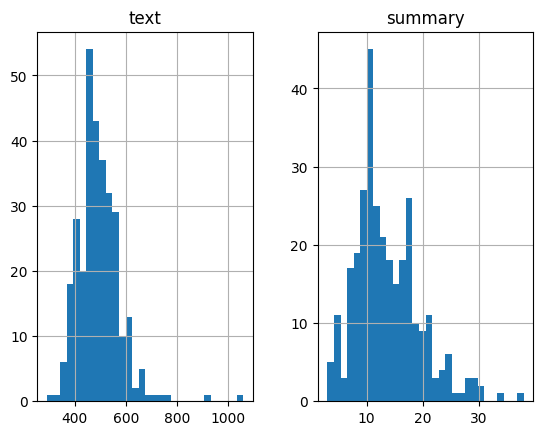

In [41]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in s2s_df['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in s2s_df['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [42]:
cnt=0
for i in s2s_df['cleaned_summary']:
    if(len(i.split())<=20):
        cnt=cnt+1
print(cnt/len(s2s_df['cleaned_summary']))

0.8819672131147541


In [43]:
cnt=0
for i in s2s_df['cleaned_text']:
    if(len(i.split())<=500):
        cnt=cnt+1
print(cnt/len(s2s_df['cleaned_text']))

0.580327868852459


In [44]:
max_text_len=500
max_summary_len=20

In [45]:
cleaned_text =np.array(s2s_df['cleaned_text'])
cleaned_summary=np.array(s2s_df['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [46]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [47]:
for i in range(5):
    print("Review:",df['text'][i])
    print("Summary:",df['summary'][i])
    print("\n")

Review: little brother trying follow school ike chortle yeah go home little dildo dude call brother dildo plastic dick go vagina others laugh heyeah kyles little brother right kyle swing ike foot knocking cartman ow ike laugh dude kick cartman laying face visitor lower pajama wa dream cartman visitor yeah abduct people mutilate cow gave anal probe cartman child watch fat boy chef walk back car picture visitor shirt word believe written cartman go catatonic chef drive bus pull away leaving ike behind bus stop kyle run front bus stop buuuuus cartman visitor saw cow start running away child friend mr hat going tell u christopher columbus cannot sit help stupid brother ill come home without dad start yelling brother kyle looking little brother kyle whispering okay okay let u ditch school go find voice rising audible level know cannot think kyle brush floss kyle ha finger kyle dude ask cartman gave anal probe hey cow cannot get train hey look wendy testaburger silence kenny wait see guy got

In [48]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

In [49]:
from keras.preprocessing.text import Tokenizer 

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [50]:
thresh=5

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 73.8544848653152
Total Coverage of rare words: 13.655475987123053


In [51]:

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   kprocessing.sequence.pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   kprocessing.sequence.pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [52]:
x_voc


1884

In [53]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [54]:
thresh=5

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 95.30271398747391
Total Coverage of rare words: 61.87729417933928


In [55]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   kprocessing.sequence.pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   kprocessing.sequence.pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [56]:
y_tokenizer.word_counts['sostok'],len(y_tr)   


(137, 137)

In [57]:
y_tokenizer.word_counts['eostok'],len(y_tr)   


(137, 137)

In [58]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [59]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [60]:
from keras import backend as K 
K.clear_session()

latent_dim = 250
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])


# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 500, 100)     188400      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 500, 250),   351000      ['embedding[0][0]']              
                                 (None, 250),                                                     
                                 (None, 250)]                                                     
                                                                                              

In [61]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [62]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [63]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],
                  batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Epoch 1/50
2/2 [==============================] - 25s 3s/step - loss: 3.8230 - val_loss: 3.1708
Epoch 2/50
2/2 [==============================] - 7s 2s/step - loss: 3.1813 - val_loss: 1.8561
Epoch 3/50
2/2 [==============================] - 7s 2s/step - loss: 1.9589 - val_loss: 0.8227
Epoch 4/50
2/2 [==============================] - 7s 2s/step - loss: 1.0335 - val_loss: 0.7712
Epoch 5/50
2/2 [==============================] - 7s 2s/step - loss: 0.9834 - val_loss: 0.8125
Epoch 6/50
2/2 [==============================] - 7s 2s/step - loss: 0.9826 - val_loss: 0.7296
Epoch 7/50
2/2 [==============================] - 7s 2s/step - loss: 0.9467 - val_loss: 0.7014
Epoch 8/50
2/2 [==============================] - 7s 2s/step - loss: 0.9480 - val_loss: 0.7190
Epoch 9/50
2/2 [==============================] - 7s 2s/step - loss: 0.9349 - val_loss: 0.8189
Epoch 9: early stopping


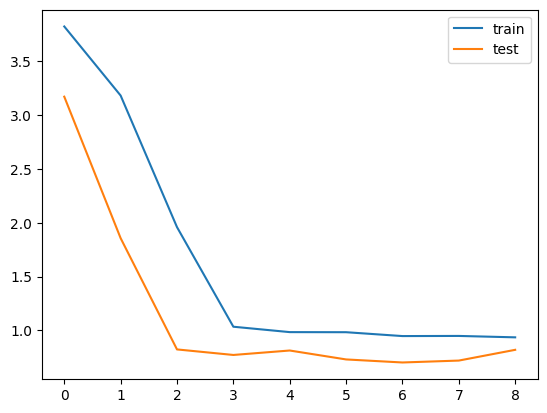

In [64]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

In [65]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [66]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [67]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [68]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [69]:
for i in range(len(x_val)):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_text_len)))
  print("\n")

Review: oh god guy going believe happened last night watching boy meet boy television eye guy come right stan kyles jacket god got neck cannot let kyle public like guy boy pull kyle along south park mall gerald sheila watch tv couch coming eye guy men lot gay show television day door open four boy enter wave hi mom hi dad eye guy guy turned gay men laugh gay gerald guy care look touch side doe mean gay anymore mean gay men look seen eye guy sheila ever since gay cool boy every night three time day dude cannot wait wendy see gay look boy look stunned silence hey dude boy look craig token tweek hey craig guy look pretty gay kyle turn leave ha second thought chef feel closeup boy kyle go seat dude stan kyle cartman kenny stay silent looking mr garrison mr slave walk street child suddenly like gay wa cool mr garrison look garrison slave walk hey doll turn back mr garrison walk away thanks like thing approach football hey guy pull stan kenny away kyle look guy lot kid school talking okay st

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2023-04-07 18:02:27--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-07 18:02:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-07 18:02:27--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.4’

gl

In [ ]:
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

In [ ]:
embeddings_dictionary = dict()
glove_file = open("glove.6B.100d.txt", encoding="utf8")
for line in glove_file:  
    records = line.split()  
    word = records[0]  
    vector_dimensions = np.asarray(records[1:], dtype='float32')               
    embeddings_dictionary [word] = vector_dimensions   

glove_file.close()

In [ ]:

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

X_dic_vocabulary = x_tokenizer.word_index

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   kprocessing.sequence.pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   kprocessing.sequence.pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

## start the matrix (length of vocabulary x vector size) with all 0s
X_embeddings = np.zeros((len(X_dic_vocabulary)+1, 100)) 

for word,idx in X_dic_vocabulary.items():
    ## update the row with vector
    try:
        X_embeddings[idx] =  embeddings_dictionary[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

y_dic_vocabulary = {"<PAD>":0}
y_dic_vocabulary.update(y_tokenizer.word_index)

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   kprocessing.sequence.pad_sequences(y_tr_seq,  maxlen=max_summary_len, padding='post')
y_val   =   kprocessing.sequence.pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary ( +1 for padding token)
y_voc   =  y_tokenizer.num_words + 1

 ## start the matrix (length of vocabulary x vector size) with all 0s
y_embeddings = np.zeros((len(y_dic_vocabulary)+1, 100)) 

for word,idx in y_dic_vocabulary.items():
    ## update the row with vector
    try:
        y_embeddings[idx] =  embeddings_dictionary[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [ ]:
X_embeddings.shape

In [ ]:
from keras import backend as K 
K.clear_session()

latent_dim = 250
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(X_embeddings.shape[0], X_embeddings.shape[1], weights=[X_embeddings], trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_embeddings.shape[0], y_embeddings.shape[1], weights=[y_embeddings], trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])


# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],
                  batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


In [ ]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(len(x_val)):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_text_len)))
  print("\n")

In [ ]:
lstm_units=250
# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(X_embeddings.shape[0], X_embeddings.shape[1], weights=[X_embeddings], trainable=True)(encoder_inputs)

### bi-lstm 1
layer_x_bilstm = layers.Bidirectional(layers.LSTM(units=lstm_units, 
                 dropout=0.2, return_sequences=True, 
                 return_state=True), name="x_lstm_1")
x_out, _, _, _, _ = layer_x_bilstm(enc_emb)
### bi-lstm 2
layer_x_bilstm = layers.Bidirectional(layers.LSTM(units=lstm_units, 
                 dropout=0.2, return_sequences=True, 
                 return_state=True), name="x_lstm_2")
x_out, _, _, _, _ = layer_x_bilstm(x_out)
### bi-lstm 3 (here final states are collected)
layer_x_bilstm = layers.Bidirectional(layers.LSTM(units=lstm_units, 
                 dropout=0.2, return_sequences=True, 
                 return_state=True), name="x_lstm_3")
x_out, forward_h, forward_c, backward_h, backward_c = layer_x_bilstm(x_out)
state_h = layers.Concatenate()([forward_h, backward_h])
state_c = layers.Concatenate()([forward_c, backward_c])

### embedding
decoder_inputs = Input(shape=(None,))

layer_y_emb = Embedding(y_embeddings.shape[0], y_embeddings.shape[1], 
               weights=[y_embeddings], trainable=False)

y_emb = layer_y_emb(decoder_inputs)

### lstm
layer_y_lstm = layers.LSTM(name="y_lstm", units=lstm_units*2, dropout=0.2, return_sequences=True, return_state=True)
y_out, _, _ = layer_y_lstm(y_emb, initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([x_out, y_out])


# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([y_out, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(y_out)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],
                  batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


In [ ]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [ ]:
# Prediction Encoder
encoder_model = models.Model(inputs=encoder_inputs, outputs=[x_out, state_h, state_c], name="Prediction_Encoder")
encoder_model.summary()

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[x_out, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h, decoder_state_input_c = layers.Input(shape=(lstm_units,)), layers.Input(shape=(lstm_units,))
decoder_hidden_state_input = Input(shape=(max_text_len,lstm_units))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
# Prediction Decoder
## double the lstm units if you used bidirectional lstm
lstm_units = lstm_units*2 if any("Bidirectional" in str(layer) for layer in model.layers) else lstm_units
## states of the previous time step
encoder_out = layers.Input(shape=(x_tr.shape[1], lstm_units))
state_h, state_c = layers.Input(shape=(lstm_units,)), layers.Input(shape=(lstm_units,))
## decoder embeddings
y_emb2 = layer_y_emb(decoder_inputs)
## lstm to predict the next word
y_out2, state_h2, state_c2 = layer_y_lstm(y_emb2, initial_state=[state_h, state_c])
## softmax to generate probability distribution over the vocabulary
probs = decoder_dense(y_out2)
## compile
decoder_model = models.Model(inputs=[decoder_inputs, encoder_out, state_h, state_c], outputs=[probs, state_h2, state_c2], name="Prediction_Decoder")
decoder_model.summary()

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(len(x_val)):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_text_len)))
  print("\n")

In [ ]:
word = "street"
embeddings_dictionary[word].shape

In [ ]:
lst_corpus = x_tr
## tokenize text
x_tokenizer = kprocessing.text.Tokenizer(num_words=x_voc, lower=False, split=' ', oov_token=None, 
filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
x_tokenizer.fit_on_texts(lst_corpus)
X_dic_vocabulary = {"<PAD>":0}
X_dic_vocabulary.update(x_tokenizer.word_index)
## create sequence
lst_text2seq= x_tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
x_tr = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=500, padding="post", truncating="post")

In [ ]:
 ## start the matrix (length of vocabulary x vector size) with all 0s
X_embeddings = np.zeros((len(X_dic_vocabulary)+1, 300)) 

for word,idx in X_dic_vocabulary.items():
    ## update the row with vector
    try:
        X_embeddings[idx] =  embeddings_dictionary[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [ ]:
## text to sequence with the fitted tokenizer
lst_text2seq = x_tokenizer.texts_to_sequences(x_val)
## padding sequence
x_val = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=500,
             padding="post", truncating="post")

In [ ]:
lst_corpus = y_tr
## tokenize text
y_tokenizer = kprocessing.text.Tokenizer(num_words=y_voc, lower=False, split=' ', oov_token=None, 
filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
y_tokenizer.fit_on_texts(lst_corpus)
y_dic_vocabulary = {"<PAD>":0}
y_dic_vocabulary.update(y_tokenizer.word_index)
## create sequence
lst_text2seq= y_tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
y_tr = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=500, padding="post", truncating="post")

In [ ]:
## text to sequence with the fitted tokenizer
lst_text2seq = x_tokenizer.texts_to_sequences(y_val)
## padding sequence
y_val = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=500,
             padding="post", truncating="post")

In [ ]:
y_embeddings = np.zeros((len(y_dic_vocabulary)+1, 300)) 

for word,idx in y_dic_vocabulary.items():
    ## update the row with vector
    try:
        y_embeddings[idx] =  embeddings_dictionary[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [ ]:
lstm_units = 250
##-------- ENCODER (pre-trained embeddings + 3 bi-lstm) ----------##
x_in = layers.Input(name="x_in", shape=(x_tr.shape[1],))
### embedding
layer_x_emb = layers.Embedding(name="x_emb",       
          input_dim=X_embeddings.shape[0], 
          output_dim=X_embeddings.shape[1], 
          weights=[X_embeddings], trainable=False)
x_emb = layer_x_emb(x_in)
### bi-lstm 1
layer_x_bilstm = layers.Bidirectional(layers.LSTM(units=lstm_units, 
                 dropout=0.2, return_sequences=True, 
                 return_state=True), name="x_lstm_1")
x_out, _, _, _, _ = layer_x_bilstm(x_emb)
### bi-lstm 2
layer_x_bilstm = layers.Bidirectional(layers.LSTM(units=lstm_units, 
                 dropout=0.2, return_sequences=True, 
                 return_state=True), name="x_lstm_2")
x_out, _, _, _, _ = layer_x_bilstm(x_out)
### bi-lstm 3 (here final states are collected)
layer_x_bilstm = layers.Bidirectional(layers.LSTM(units=lstm_units, 
                 dropout=0.2, return_sequences=True, 
                 return_state=True), name="x_lstm_3")
x_out, forward_h, forward_c, backward_h, backward_c = layer_x_bilstm(x_out)
state_h = layers.Concatenate()([forward_h, backward_h])
state_c = layers.Concatenate()([forward_c, backward_c])

##------ DECODER (pre-trained embeddings + lstm + dense) ---------##
y_in = layers.Input(name="y_in", shape=(None,))
### embedding
layer_y_emb = layers.Embedding(name="y_emb", 
               input_dim=y_embeddings.shape[0], 
               output_dim=y_embeddings.shape[1], 
               weights=[y_embeddings], trainable=False)
y_emb = layer_y_emb(y_in)
### lstm
layer_y_lstm = layers.LSTM(name="y_lstm", units=lstm_units*2, dropout=0.2, return_sequences=True, return_state=True)
y_out, _, _ = layer_y_lstm(y_emb, initial_state=[state_h, state_c])
### final dense layers
layer_dense = layers.TimeDistributed(name="dense", 
              layer=layers.Dense(units=len(y_dic_vocabulary), 
               activation='softmax'))
y_out = layer_dense(y_out)

##---------------------- COMPILE ---------------------------------##
model = models.Model(inputs=[x_in, y_in], outputs=y_out, 
                     name="Seq2Seq")
model.compile(optimizer='rmsprop',   
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
training = model.fit(x=[x_tr, y_tr[:,:-1]], 
                     y=y_tr.reshape(y_tr.shape[0], 
                                       y_tr.shape[1], 
                                       1)[:,1:],
                     batch_size=128, 
                     epochs=100, 
                     shuffle=True, 
                     verbose=1, 
                     validation_split=0.3,
                     callbacks=[callbacks.EarlyStopping(
                                monitor='val_loss', 
                                mode='min', verbose=1, patience=2)])

In [ ]:
plt.plot(training.history['loss'], label='train') 
plt.plot(training.history['val_loss'], label='test') 
plt.legend() 
plt.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [ ]:
# Prediction Encoder
encoder_model = models.Model(inputs=x_in, outputs=[x_out, state_h, state_c], name="Prediction_Encoder")
encoder_model.summary()

In [ ]:
# Prediction Decoder
## double the lstm units if you used bidirectional lstm
lstm_units = lstm_units*2 if any("Bidirectional" in str(layer) for layer in model.layers) else lstm_units
## states of the previous time step
encoder_out = layers.Input(shape=(x_tr.shape[1], lstm_units))
state_h, state_c = layers.Input(shape=(lstm_units,)), layers.Input(shape=(lstm_units,))
## decoder embeddings
y_emb2 = layer_y_emb(y_in)
## lstm to predict the next word
y_out2, state_h2, state_c2 = layer_y_lstm(y_emb2, initial_state=[state_h, state_c])
## softmax to generate probability distribution over the vocabulary
probs = layer_dense(y_out2)
## compile
decoder_model = models.Model(inputs=[y_in, encoder_out, state_h, state_c], outputs=[probs, state_h2, state_c2], name="Prediction_Decoder")
decoder_model.summary()

In [ ]:
special_tokens = ("sostok", "eostok")

# Predict
max_seq_lenght = x_val.shape[1]
predicted = []
for x in x_val:
   x = x.reshape(1,-1)
   ## encode X
   encoder_out, state_h, state_c = encoder_model.predict(x)
   ## prepare loop
   y_in = np.array([y_tokenizer.word_index[special_tokens[0]]])
   predicted_text = ""
   stop = False
   while not stop:
        ## predict dictionary probability distribution
        probs, new_state_h, new_state_c = decoder_model.predict(
                          [y_in, encoder_out, state_h, state_c])
        
        ## get predicted word
        voc_idx = np.argmax(probs[0,-1,:])
        pred_word = y_tokenizer.index_word[voc_idx]
        
        ## check stop
        if (pred_word != special_tokens[1]) and (len(predicted_text.split()) < max_seq_lenght):
            predicted_text = predicted_text +" "+ pred_word
        else:
            stop = True
        
        ## next
        y_in = np.array([voc_idx])
        state_h, state_c = new_state_h, new_state_c
   predicted_text = predicted_text.replace(
                    special_tokens[0],"").strip()
   predicted.append(predicted_text)

In [ ]:
x

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(len(x_val)):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_text_len)))
  print("\n")

In [ ]:
s2s_df['clean_summary']= s2s_df.Summary.apply(lambda x: utils_preprocess_text(x))

In [ ]:
s2s_df.head()

In [ ]:
s2s_df['text_word_count'] = s2s_df.clean_text.apply(lambda x: len(word_tokenize(str(x))))
s2s_df['summary_word_count'] = s2s_df.clean_summary.apply(lambda x: len(word_tokenize(str(x))))
s2s_df

In [ ]:
sns.displot(s2s_df.text_word_count, kde=True)

In [ ]:
s2s_df = s2s_df.drop(s2s_df[(s2s_df['text_word_count'] > 4000)].index)
sns.displot(s2s_df.text_word_count, kde=True)

In [ ]:
max_len_text = np.percentile(s2s_df.text_word_count, 95)

In [ ]:
sns.displot(s2s_df.summary_word_count, kde=True)

In [ ]:
max_len_summ = np.percentile(s2s_df.summary_word_count, 95)

In [ ]:
max_summary_len = 30
max_text_len = 3600
cleaned_text =np.array(s2s_df['cleaned_text'])
cleaned_summary=np.array(s2s_df['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
s2s_df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
s2s_df['summary'] = s2s_df['summary'].apply(lambda x : '_START_ '+ x + ' _END_')


In [ ]:
from sklearn.model_selection import train_test_split
X = s2s_df['cleaned_text']
y = s2s_df['cleaned_summary']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
from keras.preprocessing.text import Tokenizer 

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(lower=False)
x_tokenizer.fit_on_texts(list(X_train))

#convert text sequences into integer sequences
X_train    =   x_tokenizer.texts_to_sequences(X_train) 
X_test   =   x_tokenizer.texts_to_sequences(X_test)

#padding zero upto maximum length
X_train    =   kprocessing.sequence.pad_sequences(X_train,  maxlen=3600, padding='post') 
X_test   =   kprocessing.sequence.pad_sequences(X_test, maxlen=3600, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [ ]:
y_tokenizer = Tokenizer(lower=False)
y_tokenizer.fit_on_texts(list(y_train))

#convert summary sequences into integer sequences
y_train    =   y_tokenizer.texts_to_sequences(y_train) 
y_test   =   y_tokenizer.texts_to_sequences(y_test) 

#padding zero upto maximum length
y_train    =   kprocessing.sequence.pad_sequences(y_train, maxlen=30, padding='post')
y_test   =   kprocessing.sequence.pad_sequences(y_test, maxlen=30, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [ ]:
from keras import backend as K 
from tensorflow.keras import callbacks, models, layers, preprocessing as kprocessing 
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, Attention
from tensorflow.keras.models import Model
from keras_self_attention import SeqSelfAttention
K.clear_session() 
latent_dim = 500 
max_len_text = 3600
# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = Attention(name='attention_layer') 
attn_out = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
history=model.fit([X_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:],
                  epochs=50,
                  callbacks=[es],
                  batch_size=512, 
                  validation_data=([X_test, y_test[:,:-1]], y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))


#history = model.fit(X_train, y_train,
 #                   epochs=50,
  #                  callbacks=[es],
  #                  batch_size=200, 
   #                 validation_data=(X_test, y_test))

In [ ]:
encoder_inputs = Input(shape=(max_len_text,))
enc_emb = Embedding(x_voc_size+1, 50, mask_zero=True, trainable=True)
encoder = Bidirectional(LSTM(64, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h,  backward_c=encoder(enc_emb)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

In [ ]:
lst_tokens = nltk.tokenize.word_tokenize(X_train.str.cat(sep=" "))
ngrams = [1]
    
## calculate
dtf_freq = pd.DataFrame()
for n in ngrams:
   dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
   dtf_n = pd.DataFrame(dic_words_freq.most_common(), columns=
                        ["word","freq"])
   dtf_n["ngrams"] = n
   dtf_freq = dtf_freq.append(dtf_n)
   dtf_freq["word"] = dtf_freq["word"].apply(lambda x: " ".join(string for string in x) )
   dtf_freq_X= dtf_freq.sort_values(["ngrams","freq"], ascending=
                         [True,False])
    
## plot
sns.barplot(x="freq", y="word", hue="ngrams", dodge=False,
 data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(30))
plt.show()

In [ ]:
lst_tokens = nltk.tokenize.word_tokenize(y_train.str.cat(sep=" "))
ngrams = [1]
    
## calculate
dtf_freq = pd.DataFrame()
for n in ngrams:
   dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
   dtf_n = pd.DataFrame(dic_words_freq.most_common(), columns=
                        ["word","freq"])
   dtf_n["ngrams"] = n
   dtf_freq = dtf_freq.append(dtf_n)
   dtf_freq["word"] = dtf_freq["word"].apply(lambda x: " ".join(string for string in x) )
   dtf_freq_y= dtf_freq.sort_values(["ngrams","freq"], ascending=
                         [True,False])
    
## plot
sns.barplot(x="freq", y="word", hue="ngrams", dodge=False,
 data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(30))
plt.show()

In [ ]:
thres = 5 #<-- min frequency
X_top_words = len(dtf_freq_X[dtf_freq_X["freq"]>thres])
y_top_words = len(dtf_freq_y[dtf_freq_y["freq"]>thres])

In [ ]:
X_top_words

In [ ]:
y_top_words

In [ ]:
from tensorflow.keras import callbacks, models, layers, preprocessing as kprocessing 
## tokenize text
tokenizer = kprocessing.text.Tokenizer(num_words=X_top_words, lower=False, split=' ', oov_token=None, 
filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(X_train)
X_dic_vocabulary = {"<PAD>":0}
X_dic_vocabulary.update(tokenizer.word_index)
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(X_train)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=None, padding="post", truncating="post")

In [ ]:
X_train.shape

In [ ]:
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(X_test)
## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=None,
             padding="post", truncating="post")

In [ ]:
y_train = y_train.apply(lambda x: f'{"<START>"} {x} {"<END>"}')
y_test = y_test.apply(lambda x: f'{"<START>"} {x} {"<END>"}')
fitted_tokenizer = kprocessing.text.Tokenizer(num_words=y_top_words, lower=False, split=' ', oov_token=None, 
filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
fitted_tokenizer.fit_on_texts(y_train)

y_dic_vocabulary = {"<PAD>":0}
y_dic_vocabulary.update(fitted_tokenizer.word_index)
## create sequence

# check example

lst_text2seq= fitted_tokenizer.texts_to_sequences(y_train)
## padding sequence
y_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=None, padding="post", truncating="post")

In [ ]:
## text to sequence with the fitted tokenizer
lst_text2seq = fitted_tokenizer.texts_to_sequences(y_test)
## padding sequence
y_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=None,
             padding="post", truncating="post")

In [ ]:
# Add START and END tokens to the summaries (y)
#y_train = y_train.apply(lambda x: f'{"<START>"} {x} {"<END>"}')
#y_test = y_test.apply(lambda x: f'{"<START>"} {x} {"<END>"}')

# check example
#y_test[225]

In [ ]:
lstm_units = 250
embeddings_size = 300
##------------ ENCODER (embedding + lstm) ------------------------##
x_in = layers.Input(name="x_in", shape=(X_train.shape[1],))
### embedding
layer_x_emb = layers.Embedding(name="x_emb", 
                               input_dim=len(X_dic_vocabulary),
                               output_dim=embeddings_size, 
                               trainable=True)
x_emb = layer_x_emb(x_in)
### lstm 
layer_x_lstm = layers.LSTM(name="x_lstm", units=lstm_units, 
                           dropout=0.4, return_sequences=True, 
                           return_state=True)
x_out, state_h, state_c = layer_x_lstm(x_emb)
##------------ DECODER (embedding + lstm + dense) ----------------##
y_in = layers.Input(name="y_in", shape=(None,))
### embedding
layer_y_emb = layers.Embedding(name="y_emb", 
                               input_dim=len(y_dic_vocabulary), 
                               output_dim=embeddings_size, 
                               trainable=True)
y_emb = layer_y_emb(y_in)
### lstm 
layer_y_lstm = layers.LSTM(name="y_lstm", units=lstm_units, 
                           dropout=0.4, return_sequences=True, 
                           return_state=True)
y_out, _, _ = layer_y_lstm(y_emb, initial_state=[state_h, state_c])
### final dense layers
layer_dense = layers.TimeDistributed(name="dense", layer=layers.Dense(units=len(y_dic_vocabulary), activation='softmax'))
y_out = layer_dense(y_out)
##---------------------------- COMPILE ---------------------------##
model = models.Model(inputs=[x_in, y_in], outputs=y_out, 
                     name="Seq2Seq")
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

In [ ]:
## train
training = model.fit(x=[X_train, y_train[:,:-1]], 
                     y=y_train.reshape(y_train.shape[0], 
                                       y_train.shape[1], 
                                       1)[:,1:],
                     batch_size=128, 
                     epochs=100, 
                     shuffle=True, 
                     verbose=1, 
                     validation_split=0.3,
                     callbacks=[callbacks.EarlyStopping(
                                monitor='val_loss', 
                                mode='min', verbose=1, patience=2)]
                      )
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [ ]:
fitted_tokenizer.word_index[special_tokens[0]]

# Text Summarization with Transformers

In [ ]:
from keras import callbacks

In [ ]:
!pip install transformers

In [ ]:
from keras import models

In [ ]:
import transformers
from transformers import pipeline

In [ ]:
bart_df = SP_df[['Title', 'Text', 'Summary']]
bart_df.head()

In [ ]:
bart_df['reduced_text'] = textrank(corpus=bart_df.Text, ratio=.05)

In [ ]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in bart_df['reduced_text']:
      text_word_count.append(len(i.split()))

for i in bart_df['Summary']:
      summary_word_count.append(len(i.split()))

bart_df['text_len'] = text_word_count
bart_length_df = pd.DataFrame({'text_len':text_word_count, 'summary_len':summary_word_count})

bart_length_df.hist(bins = 30)
plt.show()

In [ ]:
bart_df.head()

In [ ]:
bart_df = bart_df[bart_df.text_len < 600]


In [ ]:
bart_df

In [ ]:
def bart(corpus):    
    nlp = transformers.pipeline("summarization")    
    lst_summaries = [nlp(txt, max_length=56, min_length=10)                    
                     for txt in corpus]    
    return lst_summaries

## Apply the function to corpus
bart_df['predicted'] = bart(bart_df["reduced_text"])

In [ ]:
bart_df.head()

In [ ]:
bart_df.predicted

In [ ]:
for i in range(5):
  print("-----------------Summary----------------")
  print(bart_df.Summary[i])
  print('-----------------Predicted--------------')
  print(bart_df.predicted[i])
  print('\n')

In [ ]:
type(bart_df.predicted[1])

In [ ]:
predictions = []
for i in range(len(bart_df.predicted)):
  predictions.append([d['summary_text'] for d in bart_df.predicted[i]])
predictions

In [ ]:
new_pred = []
for i in range(len(bart_df)):
  new_pred.append(predictions[i])

In [ ]:
bart_df['predicted'] = new_pred

In [ ]:
bart_df['predicted'].astype(str)

In [ ]:

import rouge
score_1 = []
score_2 = []
score_L = []

for i in range(len(bart_df)):   
    rouge_score = rouge.Rouge()    
    scores = rouge_score.get_scores(bart_df.Summary[i], bart_df.predicted[i], avg=True)       
    score_1.append(round(scores['rouge-1']['f'], 2))
    score_2.append(round(scores['rouge-2']['f'], 2))
    score_L.append(round(scores['rouge-l']['f'], 2))    
    
bart_df["Score_1"] = score_1
bart_df['Score_2'] = score_2
bart_df['Score_L'] = score_L

In [ ]:
SP_df.head()

In [ ]:
sns.displot(SP_df["Score_1"], kde=True)
plt.xlabel("Rouge-1 Scores")
plt.ylabel("Count")
plt.title('TextRank Rouge-1 Scores')
plt.axvline(SP_df.Score_1.mean(),
            color='red', label=round(SP_df.Score_1.mean(),2))
plt.legend();

In [ ]:
sns.displot(SP_df["Score_2"], kde=True)
plt.xlabel("Rouge-2 Scores")
plt.ylabel("Count")
plt.title('TextRank Rouge-2 Scores')
plt.axvline(SP_df.Score_2.mean(),
            color='red');

In [ ]:
sns.displot(SP_df["Score_L"], kde=True)
plt.xlabel("Rouge-L Scores")
plt.ylabel("Count")
plt.title('TextRank Rouge-L Scores')
plt.axvline(SP_df.Score_L.mean(),
            color='red', label=round(SP_df.Score_L.mean(),2))
plt.legend();

In [ ]:
SP_df['Score_avg'] = np.mean(SP_df[['Score_1', 'Score_L']], axis=1)
sns.displot(SP_df["Score_avg"], kde=True)
plt.xlabel("Average Rouge Scores")
plt.ylabel("Count")
plt.title('TextRank Average Rouge Scores')
plt.axvline(SP_df.Score_L.mean(),
            color='red', label=round(SP_df.Score_avg.mean(),2))
plt.legend();

In [ ]:
summarizer = transformers.pipeline('summarization')

bart_df.pred_summary = summarizer(bart_df['reduced_text'][], min_length=10, max_length=56)
summary

In [ ]:
from tensorflow import keras

In [ ]:
SP_df.Text[10]

In [ ]:
len(SP_df.Text[10])

In [ ]:
SP_df.Description[10]

In [ ]:
SP_df['text_count'] = [len(sentence.split()) for sentence in SP_df.Line]
SP_df['summary_count'] = [len(sentence.split()) for sentence in SP_df.Description]

SP_df.text_count.hist(bins=100, figsize=(15,8), grid=False);

In [ ]:
SP_df.summary_count.hist(bins='auto', figsize=(15,8), grid=False);

In [ ]:
from wordcloud import WordCloud
import seaborn as sns
import numpy as np
from random import randint

# To customize colours of wordcloud texts
def wc_blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(258, 67%%, %d%%)" % randint(60, 100)


# plot wordcloud
def plot_wordcloud(text, color_func):
    wc = WordCloud(width=1200, height=600, random_state=0).generate(text)

    f, axs = plt.subplots(figsize=(20, 10))
    with sns.axes_style("ticks"):
        sns.despine(offset=10, trim=True)
        plt.imshow(wc.recolor(color_func=color_func, random_state=0), interpolation="bilinear")
        plt.xlabel('WordCloud')

In [ ]:
plot_wordcloud(' '.join(SP_df.Description.values.tolist()), wc_blue_color_func)

In [ ]:
plot_wordcloud(' '.join(SP_df.Line.values.tolist()), wc_blue_color_func)